In [1]:
import numpy as np
import astropy.units as u
import math as mh
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import power_spectra as spe
import fourier_estimators as fou
import boxes
import bigfile
import subprocess
import os.path

In [2]:
def get1dps(snapshot_dir = '.', snapshot_num=14, grid_width=20, spectral_res=50*u.km/u.s, reload_snapshot=True, label=None):
    if reload_snapshot == False:
        try:
            reload_snapshot=False
            spectra = boxes.SimulationBox(snapshot_num, snapshot_dir, grid_width, spectral_res, reload_snapshot=reload_snapshot)
        except OSError: 
            reload_snapshot = True
            spectra = boxes.SimulationBox(snapshot_num, snapshot_dir, grid_width, spectral_res, reload_snapshot=reload_snapshot)
    else:
        spectra = boxes.SimulationBox(snapshot_num, snapshot_dir, grid_width, spectral_res, reload_snapshot=reload_snapshot)

    spectra.convert_fourier_units_to_distance = True
    tau = spectra.get_optical_depth()
    tau_scaling = 1.
    mean_flux = np.mean(np.exp(-1.*tau*tau_scaling))
    #print('The mean flux is: ', mean_flux)
    spectra_box = spectra.skewers_realisation_hydrogen_overdensity()

    fourier_estimator_instance = fou.FourierEstimator1D(spectra_box)
    result = fourier_estimator_instance.get_flux_power_1D()
    x = np.arange(len(result))*2*np.pi/boxsize
    return result, x, mean_flux, spectra._redshift

In [3]:
def get3dps(snapshot_directory, snapshot):
    filename = snapshot_directory + '/PK-DM-PART_{0:03d}'.format(snapshot)
    if os.path.exists(filename):
        data = np.genfromtxt(filename, names= ['k', 'p'])
    else:
        command = '/mnt/home/landerson/src/GenPK/gen-pk -i {0}/PART_{1:03d} -o {2}'.format(snapshot_dir_pre + s, sn, snapshot_dir_pre + s)
        process = subprocess.Popen(command, shell=True, stdout=subprocess.PIPE)
        exit_code = process.wait()
        data = np.genfromtxt(filename, names=['k', 'p'])
    return data['p'], data['k']
    

In [4]:
def lnMeanFlux(z):
    return np.log(0.8)*((1. + z)/3.25)**3.2

40000  sightlines. resolution:  50.029683531  z= 98.0
Size of voxels in velocity units = {'x': <Quantity 52.78131612516788 km / s>, 'y': <Quantity 52.78131612516788 km / s>, 'z': <Quantity 50.029683530964824 km / s>}
40000  sightlines. resolution:  50.029683531  z= 98.0
Size of voxels in velocity units = {'x': <Quantity 52.78131612516788 km / s>, 'y': <Quantity 52.78131612516788 km / s>, 'z': <Quantity 50.029683530964824 km / s>}
40000  sightlines. resolution:  50.1384672124  z= 9.0
Size of voxels in velocity units = {'x': <Quantity 16.7963865161528 km / s>, 'y': <Quantity 16.7963865161528 km / s>, 'z': <Quantity 50.13846721239642 km / s>}
40000  sightlines. resolution:  50.1384672124  z= 9.0
Size of voxels in velocity units = {'x': <Quantity 16.7963865161528 km / s>, 'y': <Quantity 16.7963865161528 km / s>, 'z': <Quantity 50.13846721239642 km / s>}


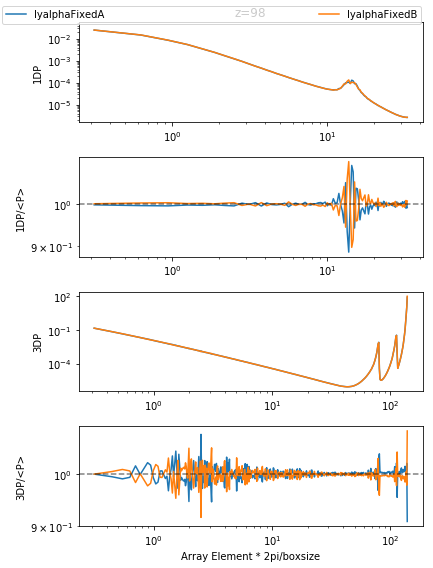

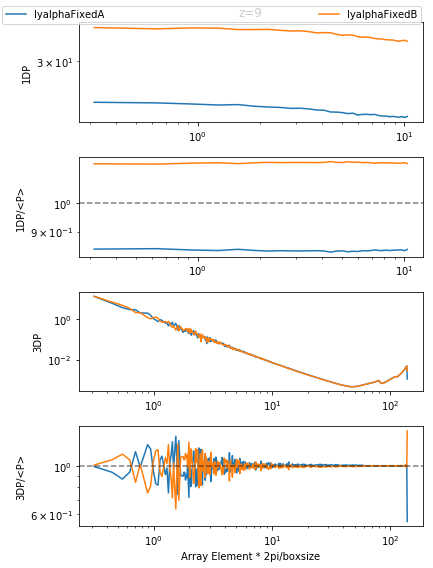

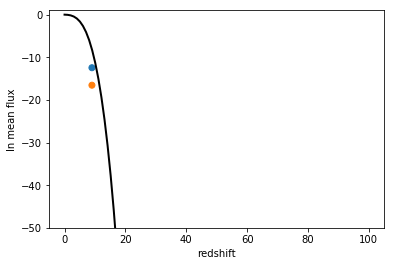

In [5]:
boxsize = 20. #Mpc/h
grid_width = [200, 200]
spectral_res = 50*u.km/u.s


snapshot_dir_pre = '/mnt/ceph/users/landerson/'
snapshot_dir = ['lyalphaFixedA', 'lyalphaFixedB'] #, 'lyalphaVaried1', 'lyalphaVaried2', 'lyalphaVaried3', 'lyalphaVaried4']
snap_nums = [0, 2]

p_corr = boxsize**3.
k_corr = 2*np.pi/boxsize


for sn, g in zip(snap_nums, grid_width):
    spectra1d= []
    k1d = []
    meanflux = []
    z = []
    spectra3d = []
    k3d = []
    legend = []
    
    fig, ax = plt.subplots(4, figsize=(6, 8)) #len(snap_nums))
    for s in snapshot_dir:
        p1d, k1dnow, mean_flux, redshift = get1dps(snapshot_num=sn, snapshot_dir = snapshot_dir_pre + s, reload_snapshot=False, label=s, grid_width=g, spectral_res=spectral_res)
        lnow, = ax[0].loglog(k1dnow, p1d, label=s)
        legend.append(lnow)
        p3d, k3dnow = get3dps(snapshot_dir_pre + s, sn)
        ax[2].loglog(k3dnow*k_corr, p3d*p_corr)
        
        spectra1d.append(p1d)
        k1d.append(k1dnow)
        
        spectra3d.append(p3d*p_corr)
        k3d.append(k3dnow*k_corr)
        
        meanflux.append(mean_flux)
        z.append(redshift)
    for kmode, spec, axis in zip([k1d, k3d], [spectra1d, spectra3d], [ax[1], ax[3]]):
        spec = np.vstack(spec)
        meanspec = np.mean(spec, axis=0)
        for kk, ss in zip(kmode, spec):
            axis.loglog(kk, ss/meanspec)
    for i in [1,3]:
        xlim = ax[i].get_xlim()
        ax[i].plot(xlim, [1.0, 1.0], linestyle='--', alpha=0.5, color='black')
        ax[i].set_xlim(xlim)
    #ax[0].set_xlim()
    #ax[0].legend()
    #ax[1].set_xlabel('Array Element * 2pi/boxsize')
    ax[3].set_xlabel('Array Element * 2pi/boxsize')
    ax[0].set_ylabel('1DP')
    ax[1].set_ylabel('1DP/<P>')
    ax[2].set_ylabel('3DP')
    ax[3].set_ylabel('3DP/<P>')
    fig.legend(legend, snapshot_dir,
           ncol=2, mode="expand", borderaxespad=0.2, bbox_to_anchor=(0., 0.98, 0.98, 0.))#, loc=3
    ax[0].set_title('z={0:01g}'.format(redshift))
    fig.tight_layout()
    fig.savefig('ps_{0:03d}.pdf'.format(sn))

colors = [l.get_c() for l in legend]    
    
figmf, axmf = plt.subplots()
axmf.scatter(z, np.log(meanflux), c=colors)
zz = np.linspace(0, 100, 100)
axmf.plot(zz, lnMeanFlux(zz), lw=2, color='black')
axmf.set_ylim(-50, 1)
axmf.set_xlabel('redshift')
axmf.set_ylabel('ln mean flux')
figmf.savefig('meanFlux.pdf')